In [10]:
%load_ext autoreload
%autoreload 2

import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.utils import shuffle
from tqdm.notebook import tqdm

import sys
sys.path.append("..")
from src.visualization.emoji_plotting import plot_emoji_barplot, emoji_scatter, offset_image
from src.analysis.embedded import calculate_vocabulary_variation, embedded_CIs
from settings import AMBIGUITY_PATH, AMBIGUITY_VARIATION, EMBEDDINGS_PATH

pd.set_option('mode.chained_assignment', None)

sns.set(rc={'figure.figsize':(15, 7)}, font_scale=1.3)
sns.set_style("white", {'axes.grid' : False})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
variations = pd.read_csv(AMBIGUITY_VARIATION)
variations.CIs = variations.CIs.apply(eval)

In [12]:
variations.head()

,emoji,vocabulary,variation,CIs
0,#️⃣,"Counter({'pound': 10, 'number': 9, 'hashtag': ...",0.496355,"[0.34049082708855466, 0.5351314574386924]"
1,*️⃣,"Counter({'asterisk': 11, 'star': 9, 'pound': 2...",0.584016,"[0.3850973823270968, 0.6565330826977255]"
2,©️,"Counter({'copyright': 17, 'copywrite': 3, 'c':...",0.276658,"[0.14734829440712927, 0.41018219388055577]"
3,®️,"Counter({'r': 7, 'registered': 3, 'copyright':...",0.576165,"[0.4251615431142488, 0.6953480601655662]"
4,‼️,"Counter({'exclamation': 11, 'important': 3, 's...",0.494922,"[0.34701899029956806, 0.6155792427859429]"


In [13]:
variations = variations.set_index("emoji")

### Create randomized baseline

In [14]:
ambiguity = pd.read_csv(AMBIGUITY_PATH, encoding='utf-8')

with open(EMBEDDINGS_PATH, "rb") as f:
    word_embeddings = pickle.load(f)
    
words = ambiguity.word

In [15]:
baselines = []
for i in tqdm(range(1000)):
    random_words = words.sample(n=30, random_state=42+i).tolist()
    random_voc = Counter(random_words)
    baselines.append(calculate_vocabulary_variation(random_voc, word_embeddings))

  0%|          | 0/1000 [00:00<?, ?it/s]

In [16]:
alpha = 5
baseline = np.nanmedian(np.array(baselines))
baselines_CIs = [np.nanpercentile(baselines, alpha / 2),\
                         np.nanpercentile(baselines, 100 - (alpha / 2))] 

#### Which emojis are only a bit more ambiguous than baseline?

In [17]:
variations[variations.variation.sub(baseline).gt(0.01)]["variation"]

emoji
💁    0.717103
💌    0.700732
📵    0.701900
🛂    0.716157
🛃    0.745275
Name: variation, dtype: float64

#### Which emojis are very close to baseline? Both sides, a bit lower than baseline, a bit higher than baseline

In [18]:
variations[variations.variation.sub(baseline).abs().lt(0.01)]["variation"]

emoji
⛎      0.692086
➿      0.692479
👩‍💼    0.689072
🧐      0.694345
Name: variation, dtype: float64

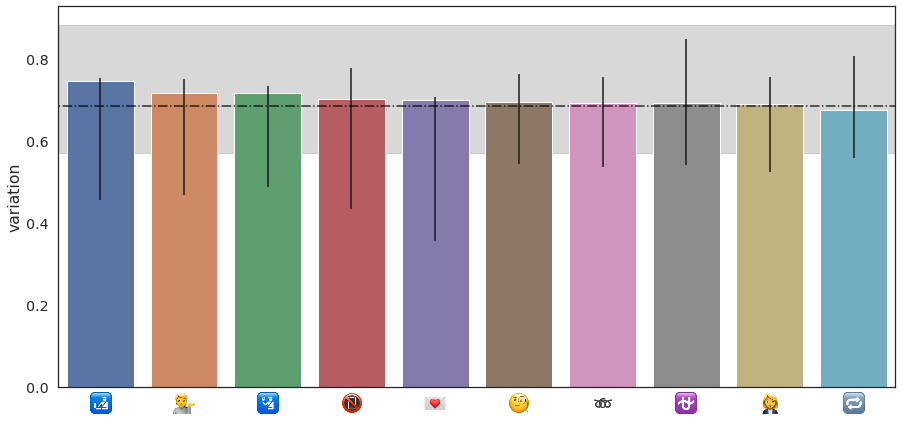

In [20]:
top_ten = variations.nlargest(10, columns='variation').reset_index()

fig, ax = plt.subplots()
ax.plot(range(-2, 12), 14*[baseline], '-.', alpha=0.8, color='black')
ax.fill_between(range(-2, 12), baselines_CIs[0],
                 baselines_CIs[1], alpha = 0.3, color='gray')
plot_emoji_barplot(top_ten, ax, col='variation')

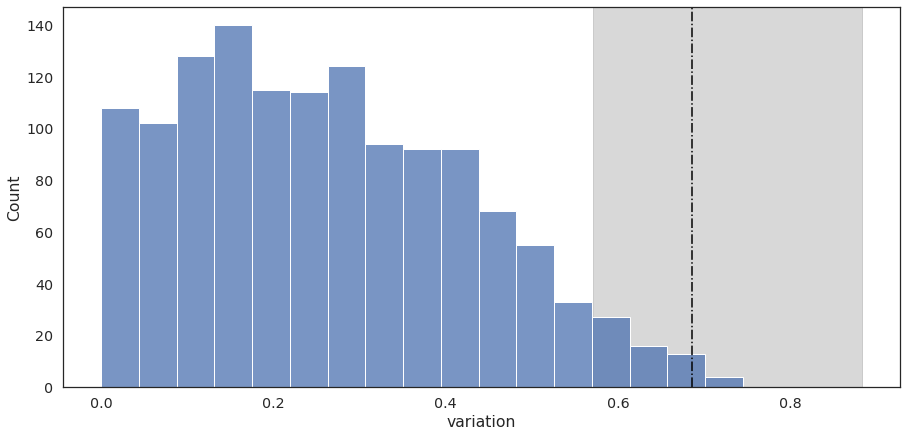

In [21]:
fig, ax = plt.subplots()


ax.axvline(baseline, linestyle="-.", color='black')
ax.axvspan(baselines_CIs[0], baselines_CIs[1], alpha=0.3, color='gray')
sns.histplot(variations.variation, ax=ax);

### Most ambiguous words in terms of in how many emojis they appear

In [22]:
ambiguity = pd.read_csv(AMBIGUITY_PATH, encoding='utf-8')
ambiguity.head()

,WorkerID,FormId,Duration,emoji_index,emoji,word
0,A19AAMLW7OP5V4,65,330.0,0,#️⃣,ash
1,A1DD23J1WBGQUU,65,315.0,0,#️⃣,hashtag
2,A2C7A6E70NYNUI,65,317.0,0,#️⃣,hashtag
3,A2CK0OXMPOR9LE,65,521.0,0,#️⃣,pound
4,A272X64FOZFYLB,65,329.0,0,#️⃣,pound


In [23]:
words_by_num_emojis = ambiguity.groupby("word").emoji.nunique()

### What is the most ambiguous word?

In [24]:
words_by_num_emojis.nlargest(n=20).reset_index().rename({"emoji":"num_emojis"}, axis=1)

,word,num_emojis
0,happy,69
1,symbol,58
2,love,43
3,man,43
4,sad,43
5,smile,41
6,sign,39
7,letter,38
8,arrow,36
9,boy,34


In [25]:
pd.set_option('display.max_rows', None)
words_by_num_emojis.sort_values(ascending=False)

word
happy                                                      69
symbol                                                     58
sad                                                        43
love                                                       43
man                                                        43
smile                                                      41
sign                                                       39
letter                                                     38
arrow                                                      36
boy                                                        34
ball                                                       33
stop                                                       32
square                                                     32
family                                                     30
chinese                                                    28
food                                                       27
gir

In [26]:
words_by_num_emojis.describe()

count    4698.000000
mean        2.333333
std         3.424790
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        69.000000
Name: emoji, dtype: float64

#### Median words in terms of ambiguity

In [27]:
words_by_num_emojis[words_by_num_emojis.sub(words_by_num_emojis.median()).abs().lt(0.001)]

word
TRUE                                                       1
aardvark                                                   1
ab                                                         1
abacus                                                     1
abbreviations                                              1
abc                                                        1
abcd                                                       1
abe                                                        1
abstract                                                   1
accepting                                                  1
accessibility                                              1
accident                                                   1
accountant                                                 1
ace aura                                                   1
achieve                                                    1
acronym                                                    1
across             

#### Mean words in terms of ambiguity

In [28]:
words_by_num_emojis[words_by_num_emojis.sub(words_by_num_emojis.mean()).abs().lt(1)]

word
abcs                   2
above                  2
accessible             2
ace                    3
acorn                  2
action                 2
add                    2
agony                  2
ahead                  3
aid                    2
airlift                2
airport                2
alarmed                2
alcohol                2
am track               2
ambulance              2
amused                 3
analyst                2
anchor                 2
ancient                2
angle                  3
anniversary            2
anonymous              2
ant                    2
antenna                2
anxious                3
apartment              2
ape                    2
app                    3
applause               2
approval               2
aquarius               2
arabic                 2
archery                2
arena                  2
arm                    2
arrows                 3
art                    3
ashamed                2
asia                

In [29]:
words_by_num_emojis = words_by_num_emojis.reset_index().rename({"emoji": "count"}, axis=1)

In [30]:
words_by_num_emojis.groupby("count").word.apply(set)

count
1     {goose, freezing, unlocked, geek, scroll, foxy...
2     {faucet, glum, slider, pisces, quizzical, ligh...
3     {bandaged, copy, sup rise, purple, not shown, ...
4     {kidding, helicopter, briefcase, sword, break,...
5     {cancel, engineer, movie, disk, blush, award, ...
6     {plane, horse, balance, desert, clip, fun, cal...
7     {old, pot, working, pause, pleased, subway, la...
8     {finger, snowflake, cycle, number, time, shoe,...
9     {anger, back, unhappy, quiet, disappointed, ex...
10    {computer, friends, police, women, rock, tools...
11    {baby, dessert, chart, turn, soup, rain, sunsh...
12    {candy, warning, bus, nervous, character, tree...
13    {laughing, speaker, horoscope, surprised, blan...
14    {wow, shocked, book, home, thinking, down, fac...
15    {signal, up, cat, money, note, astrology, work...
16    {ship, train, person, animal, bowl, travel, ni...
17             {water, mail, work, zodiac, funny, hand}
18        {upset, button, fish, house, flo